# Question 6

In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from random import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
global network
global gl_errors

### (a) Import and explore data.

In [215]:
# import the data
train_ = pd.read_csv('train_data.csv')
test = pd.read_csv('validate_data.csv')
train_.shape, test.shape

((410, 3), (82, 3))

In [216]:
train_.describe()

,X_1,X_2,y
count,410.000000,410.000000,410.000000
mean,4895.705237,4973.234806,0.500000
std,2860.877356,3119.801712,0.500611
min,27.557777,29.069434,0.000000
25%,2341.140941,2124.504836,0.000000
50%,4987.225191,5701.130455,0.500000
75%,7303.607081,7762.583984,1.000000
max,9941.145899,9960.403013,1.000000


The range of X1 and X2 feature:9913.588 and 9931.334.



(array([38., 55., 37., 46., 29., 41., 45., 37., 50., 32.]),
 array([  27.55777723, 1018.91658941, 2010.27540158, 3001.63421376,
        3992.99302594, 4984.35183811, 5975.71065029, 6967.06946247,
        7958.42827465, 8949.78708682, 9941.145899  ]),
 <a list of 10 Patch objects>)

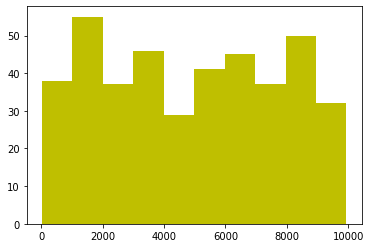

In [217]:
# explore the data
a = np.max(train_['X_1'])-np.min(train_['X_1'])
b = np.max(train_['X_2'])-np.min(train_['X_2'])
print('The range of X1 and X2 feature:%.3f and %.3f.\n'%(a,b))
pyplot.hist(train_['X_1'], color='y')

(array([52., 45., 54., 35., 14., 23., 41., 53., 48., 45.]),
 array([  29.06943404, 1022.20279194, 2015.33614983, 3008.46950773,
        4001.60286562, 4994.73622352, 5987.86958142, 6981.00293931,
        7974.13629721, 8967.2696551 , 9960.403013  ]),
 <a list of 10 Patch objects>)

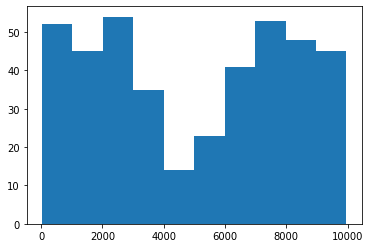

In [218]:
pyplot.hist(train_['X_2'])

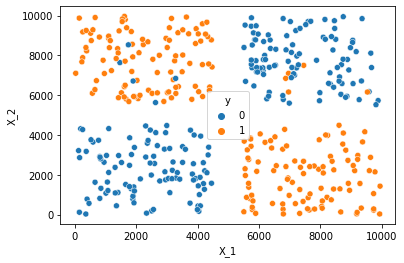

In [219]:
sns.scatterplot(x=train_['X_1'], y=train_['X_2'], hue=train_['y'])

### (b) Normalization
We choose to use **min-max normalization** since the data distribution is not close to the normal distribution, which is not suitble for the Zero-mean-unit-variance normalization. Besides, the range of feature X1 and X2 of training data is huge; thus, we would like to scale them in the range of [0,1].The formular we used for updating each datapoing is as follows.

\begin{align}
x_i = \frac{x_i-min(x_i)}{max(x_i) - min(x_i)}
\end{align}

In [220]:
# Data normalization function
def min_max_norm(data):
    for col in data[['X_1','X_2']]:
        max = np.max(data[col])
        min = np.min(data[col])
        sub = max - min
        for i in range(data.shape[0]):
            data[col][i] = (data[col][i] - min)/sub

In [221]:
# using normalization and report the first four training samples after transformation
min_max_norm(train_)
min_max_norm(test)
train_.head(4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,X_1,X_2,y
0,0.291484,0.328300,0
1,0.187760,0.075766,0
2,0.419723,0.153595,0
3,0.818876,0.984258,0


In [222]:
# Split the train_x, train_y, test_x and test_y
X_train = train_.iloc[:,0:2].to_numpy()
X_test = test.iloc[:,0:2].to_numpy()
y_train = train_.iloc[:,2].to_numpy()
y_test = test.iloc[:,2].to_numpy()

### (c) Determine the size of the input and output layer.
The size of the input layer is $1\times2$, and the size output layer of the whole MLP is $1\times2$ as well since this is a binary classification problem.

### (d) Choose a suitable loss function and activation function.
We choose **a simple loss function** and **ReLU** as our loss function and activation function, respectively. We only use a simple loss function, which is calculated by the subtraction of the predicted labels and the true labels. The **ReLU** activation function is chosen as it can also avoid the gradient vanishing. 

In order to get output from the MLP that actually works for this and is in the desired form, we use a **Softmax** function as activation between the final MLP layer and the output.

In [223]:
# implement the activation function and its derivative
def activation(x):
    return 1 / (1 + np.exp(-x))

def activation_derivative(x):
    s = activation(x)
    ds = s*(1-s)
    return ds

In [224]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum()

### (e) Choose an initialization of the parameter values.

In [225]:
# Define the hyperparameters. Add any additional hyperparameters you might need
lr = 0.05  # learning rate
minibatch_size = 25
num_epochs = 200
early_stop_threshold = 8

### (f) Implement the MLP network

In [226]:
n_feature = 2
n_class = 2


def make_network(n_hidden=10):
    # Initialize weights with Standard Normal random variables
    model = dict(
        W1=np.random.randn(n_feature, n_hidden),
        W2=np.random.randn(n_hidden, n_class)
    )

    return model

In [227]:
def forward_pass(x, model):
    # Input to hidden
    h = x @ model['W1']
    # ReLU non-linearity
    h[h < 0] = 0
    # Hidden to output
    prob = softmax(h @ model['W2'])

    return h, prob

In [228]:
def backward_pass(model, xs, hs, errs):
    dW2 = hs.T @ errs

    dh = errs @ model['W2'].T
    dh[hs <= 0] = 0

    dW1 = xs.T @ dh

    return dict(W1=dW1, W2=dW2)

In [229]:
def get_minibatch_grad(model, X_train, y_train):
    xs, hs, errs = [], [], []

    for x, cls_idx in zip(X_train, y_train):
        h, y_pred = forward_pass(x, model)

        # Create probability distribution of true label
        y_true = np.zeros(n_class)
        y_true[int(cls_idx)] = 1.

        # Compute the gradient of output layer
        err = y_true - y_pred

        xs.append(x)
        hs.append(h)
        errs.append(err)

    return backward_pass(model, np.array(xs), np.array(hs), np.array(errs))

In [230]:
def calculate_accuracy_and_loss(predicted, truth):
    correct = 0
    wrong = 0
    errs = []
    
    for i in range(len(predicted)):
        errs.append(predicted[i] - truth[i])
        
        if predicted[i] == truth[i]:
            correct += 1
        else:
            wrong += 1
    
    accuracy = correct / (correct + wrong)
    
    return accuracy, np.array(errs).mean()

In [231]:
# define stopping criteria for training
def stopping_criteria(early_stop_state):
    if early_stop_state['epoch_val_accuracy'] <= early_stop_state['best_val_accuracy']:
        early_stop_state['no_improvement_count'] += 1
    else:
        early_stop_state['best_val_accuracy'] = early_stop_state['epoch_val_accuracy']
        early_stop_state['no_improvement_count'] = 0
    
    if early_stop_state['no_improvement_count'] >= early_stop_threshold:
        stop = True
    else:
        stop = False
    
    return stop

In [232]:
def sgd(model, X_train, y_train, minibatch_size):
    epoch = 1
    
    train_losses = []
    val_losses = []
    train_accuracy_list = []
    val_accuracy_list = []
    
    early_stop_state = {"best_val_accuracy": 0.00,
                        "epoch_val_accuracy": 0.00,
                        "no_improvement_count": 0}

    while not stopping_criteria(early_stop_state):
        if epoch > num_epochs:
            # Max was reached without hitting stopping criteria
            break
            
        # print('Iteration {}'.format(iter))

        # Randomize data point
        # X_train, y_train = shuffle(X_train, y_train)
        
        for i in range(0, X_train.shape[0], minibatch_size):
            # Get pair of (X, y) of the current minibatch/chunk
            X_train_mini = X_train[i:i + minibatch_size]
            y_train_mini = y_train[i:i + minibatch_size]

            model = sgd_step(model, X_train_mini, y_train_mini)
        
        # After this epoch of training, how does the model perform on training & validation datasets?
        y_pred_train = np.zeros_like(y_train)
        y_pred_test = np.zeros_like(y_test)
        
        for i, x in enumerate(X_train):
            # Predict the distribution of label
            _, prob = forward_pass(x, model)
            # Get label by picking the most probable one
            y = np.argmax(prob)
            y_pred_train[i] = y
            
        for i, x in enumerate(X_test):
            # Predict the distribution of label
            _, prob = forward_pass(x, model)
            # Get label by picking the most probable one
            y = np.argmax(prob)
            y_pred_test[i] = y
        
        train_accuracy, train_loss = calculate_accuracy_and_loss(y_pred_train, y_train)
        train_accuracy_list.append(train_accuracy)
        train_losses.append(train_loss)
        
        validation_accuracy, val_loss = calculate_accuracy_and_loss(y_pred_test, y_test)
        val_accuracy_list.append(validation_accuracy)
        val_losses.append(val_loss)
        early_stop_state["epoch_val_accuracy"] = validation_accuracy
        
        epoch += 1

    return model, train_accuracy_list, val_accuracy_list, train_losses, val_losses

In [233]:
def sgd_step(model, X_train, y_train):
    grad = get_minibatch_grad(model, X_train, y_train)
    model = model.copy()

    # Update every parameters in our networks (W1 and W2) using their gradients
    for layer in grad:
        # Learning rate: 1e-2
        model[layer] += 0.1 * grad[layer]

    return model

In [234]:
model = make_network()

# Train the model
model, train_accuracy_list, val_accuracy_list, train_losses, val_losses = sgd(model, X_train, y_train, minibatch_size)

# The last entries in train_accuracy_list and val_accuracy_list are the
#   versions that are the now fully trained model running on the data
final_train_accuracy = train_accuracy_list[-1]
final_validation_accuracy = val_accuracy_list[-1]

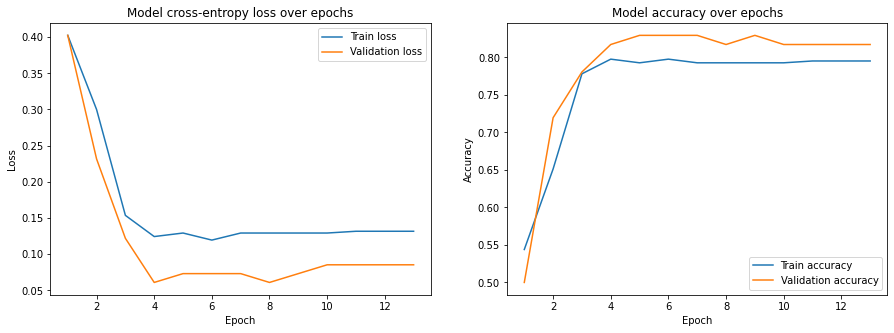

In [235]:
# Plots for cross-entropy and accuracy

# X axis labels: the epoch at which each value was achieved
x_axis_labels = [i for i in range(1, len(train_losses)+1)]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (15,5))

# Loss plot
ax0.plot(x_axis_labels, train_losses, label="Train loss")
ax0.plot(x_axis_labels, val_losses, label="Validation loss")

ax0.legend()
ax0.set_title('Model cross-entropy loss over epochs')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')

# Accuracy plot
x_axis_labels = [i for i in range(1, len(train_accuracy_list)+1)]

ax1.plot(x_axis_labels, train_accuracy_list, label="Train accuracy")
ax1.plot(x_axis_labels, val_accuracy_list, label="Validation accuracy")

ax1.legend()
ax1.set_title('Model accuracy over epochs')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

plt.show()

### (g) Tune the hyperparameters: learning rate, batch size, number of epochs. Report the best values for each hyperparameter.

In [236]:
train_accuracy = train_accuracy_list[-1]
val_accuracy = val_accuracy_list[-1]

train_predictions = []
val_predictions = []

for i, x in enumerate(X_train):
    # Predict the distribution of label
    _, prob = forward_pass(x, model)
    # Get label by picking the most probable one
    y = np.argmax(prob)
    train_predictions.append(y)
            
for i, x in enumerate(X_test):
    # Predict the distribution of label
    _, prob = forward_pass(x, model)
    # Get label by picking the most probable one
    y = np.argmax(prob)
    val_predictions.append(y)

train_confusion = confusion_matrix(y_train, train_predictions)
val_confusion = confusion_matrix(y_test, val_predictions)

print('Final accuracy scores:')
print(f'Train set: {round(train_accuracy, 2)}')
print(f'Validation set: {round(val_accuracy, 2)}')

Final accuracy scores:
Train set: 0.8
Validation set: 0.82


Confusion matrix on train data:


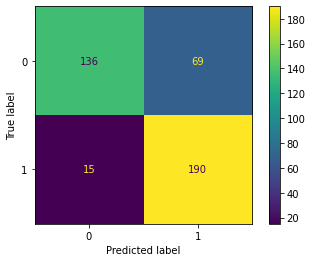

In [237]:
print("Confusion matrix on train data:")
display = ConfusionMatrixDisplay(confusion_matrix=train_confusion)
display.plot()
plt.show()

Confusion matrix on validation data:


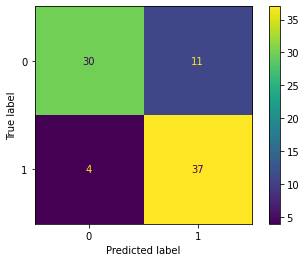

In [238]:
print("Confusion matrix on validation data:")
display = ConfusionMatrixDisplay(confusion_matrix=val_confusion)
display.plot()
plt.show()